In [1]:
from collections import defaultdict, Counter
import pandas as pd
from bert_score import score as bert_score
from nlgeval import NLGEval
import seaborn as sns
from nltk import ngrams

In [2]:
# _df = pd.concat([
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_food.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_indoor.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_outdoor.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_vehicles.csv', error_bad_lines=False, warn_bad_lines=True)
# ])

_df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/12oct/zero.csv', error_bad_lines=False, warn_bad_lines=True)



/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_57848/2176486036.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  _df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/12oct/zero.csv', error_bad_lines=False, warn_bad_lines=True)
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_57848/2176486036.py:9: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  _df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/12oct/zero.csv', error_bad_lines=False, warn_bad_lines=True)


In [3]:
# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['interpreter domain'].unique())
_df = _df.dropna()
print('Data points:', len(_df))

id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

df = ood_df
df.head(2)


target domain   : ['outdoor' 'indoor']
listener domain : ['food']
simulator domain: ['food']
Data points: 323


,Unnamed: 0,target domain,listener domain,interpreter domain,target img idx,img path #0,img path #1,img path #2,img path #3,img path #4,...,int_list_acc10,int_list_acc11,int_list_acc12,int_list_acc13,int_list_acc14,int_list_acc15,int_list_acc16,int_list_acc17,int_list_acc18,int_list_acc19
2,3774,outdoor,food,food,4,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,...,0,0,0,0,0,0,0,0,0,0
6,3778,outdoor,food,food,1,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,/home/ecekt/adp/pb_speaker_adaptation/dataset/...,...,0,0,0,0,0,0,0,0,0,0


In [4]:
refs = df['golden utt'].tolist()
refs_for_nlgeval = [[ref] for ref in refs]
hyps = {
    "h0": df['original utt'].tolist(),
    "h0' 0": df['adapted utt s0'].tolist(),
    "h0' 1": df['adapted utt s1'].tolist(),
    "h0' 2": df['adapted utt s2'].tolist(),
    "h0' 3": df['adapted utt s3'].tolist(),
    "h0' 4": df['adapted utt s4'].tolist()
}


## Utterance length

In [5]:
lengths = defaultdict(list)

for ref in refs:
    lengths['ref'].append(len(ref.strip().split()))

for hyp_type in hyps:
    for hyp in hyps[hyp_type]:
        lengths[hyp_type].append(len(hyp.strip().split()))

len_df = pd.DataFrame(lengths.values(), index=lengths.keys()).T


<AxesSubplot:>

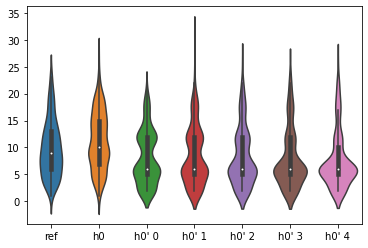

In [6]:
sns.violinplot(data=len_df)

## Repetitions

In [7]:
def ngram_reps(text, n=1):
    token_seq = text.strip().split()
    ngram_seq = list(ngrams(token_seq, n))
    if len(ngram_seq) <= 1:
        return 0.

    ngram_counter = Counter(ngram_seq)
    n_repeated_tokens = 0
    n_repeated_types = 0
    for w in ngram_counter:
        if ngram_counter[w] > 1:
            n_repeated_tokens += ngram_counter[w]
            n_repeated_types += 1

    return (n_repeated_tokens - n_repeated_types) / len(ngram_seq)


In [8]:
reps = defaultdict(lambda: defaultdict(list))

for N in range(1, 4):
    for ref in refs:
        reps[N]['ref'].append(ngram_reps(ref, n=N))

    for hyp_type in hyps:
        for hyp in hyps[hyp_type]:
            reps[N][hyp_type].append(ngram_reps(hyp, n=N))

rep_df_1 = pd.DataFrame(reps[1].values(), index=reps[1].keys()).T
rep_df_2 = pd.DataFrame(reps[2].values(), index=reps[2].keys()).T
rep_df_3 = pd.DataFrame(reps[3].values(), index=reps[3].keys()).T

<AxesSubplot:>

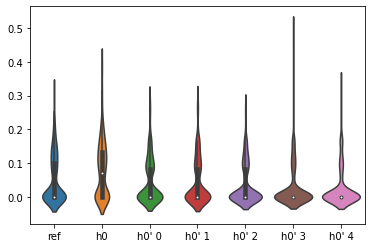

In [9]:
sns.violinplot(data=rep_df_1)

<AxesSubplot:>

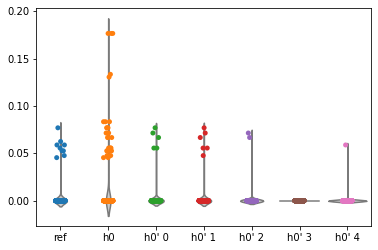

In [10]:
sns.violinplot(data=rep_df_2, inner=None, color=".8")
sns.stripplot(data=rep_df_2)

<AxesSubplot:>

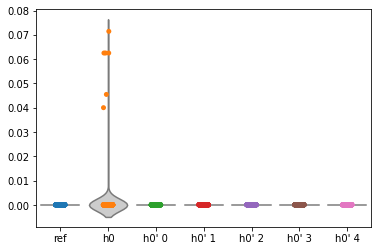

In [11]:
sns.violinplot(data=rep_df_3, inner=None, color=".8")
sns.stripplot(data=rep_df_3)

## Classic NLG metrics

In [12]:
nlgeval = NLGEval(no_skipthoughts=True, no_glove=True, metrics_to_omit=['METEOR'])

score_dicts = []
for hyp_type in hyps:
    metrics_dict = nlgeval.compute_metrics(refs_for_nlgeval, hyps[hyp_type])
    (P, R, F)= bert_score(
        hyps[hyp_type],
        refs,
        lang="en",
        return_hash=False,
        model_type="microsoft/deberta-xlarge-mnli",
    )
    metrics_dict['BERT_P'] = P.mean().item()
    metrics_dict['BERT_R'] = R.mean().item()
    metrics_dict['BERT_F'] = F.mean().item()
    score_dicts.append(metrics_dict)

score_df = pd.DataFrame(score_dicts, index=hyps.keys())

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture

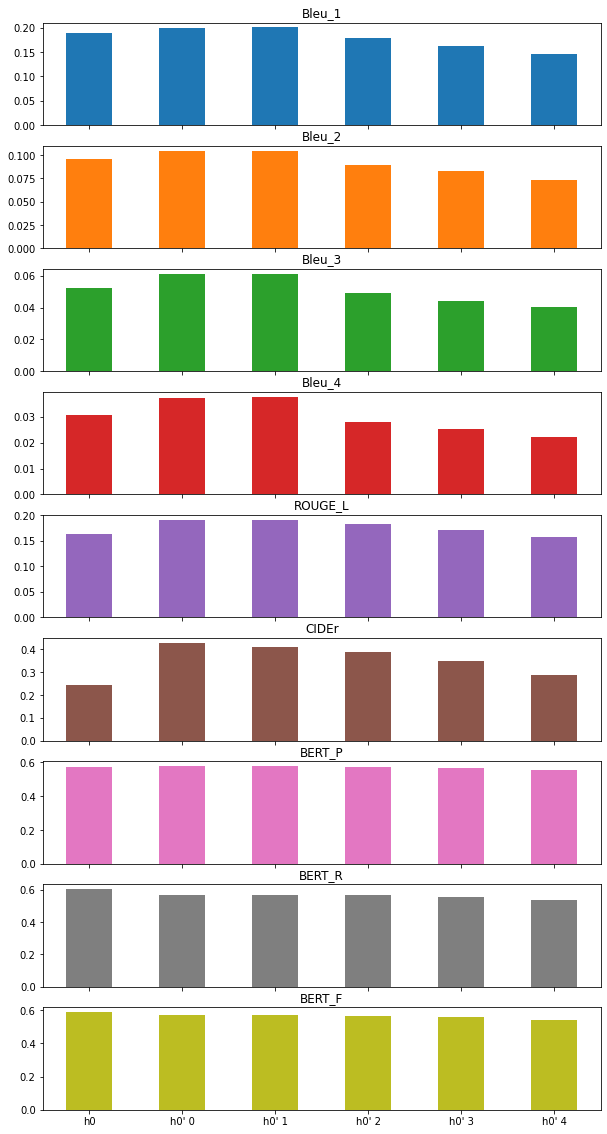

In [13]:
axes = score_df.plot.bar(rot=0, subplots=True, figsize=(10,20), legend=None)
# axes[1].legend()